# <center> </center>
# <center> 7c. VEC Application
## <center> ECO374

If using Colab, mount Google Drive and set path to files

In [1]:
import os
IN_COLAB = 'COLAB_GPU' in os.environ  
if IN_COLAB:
  from google.colab import drive; mount_path = '/content/drive'
  not os.path.ismount(mount_path) and drive.mount(mount_path)
  os.chdir('/content/drive/MyDrive/Colab Notebooks/Python_code') # Set Python file directory

Set up R for Python

In [2]:
import R_for_Python_setup as RPY
RPY.setup_R()
ro, pandas2ri, StrVector = RPY.initialize_rpy2()
%load_ext rpy2.ipython

R installed
Operating system: Windows
Development tool: Anaconda


Load R packages

In [3]:
R_packages = ['tsDyn', 'urca']
RPY.load_R_packages(R_packages)

R packages loaded: tsDyn, urca


Load Python libraries

In [4]:
pth_packages = ['pandas_datareader']
import subprocess, sys
for pkg in pth_packages: subprocess.run([sys.executable, '-m', 'pip', 'install', pkg, '--quiet'], check=True)
import numpy as np, pandas as pd, pandas_datareader.data as web, datetime as dt
import matplotlib.pyplot as plt, matplotlib.dates as mdates, statsmodels.api as sm
from tabulate import tabulate; import warnings; warnings.filterwarnings("ignore")

# 1. Data

Production and Consumption: U.S. Personal Consumption Expenditure (PCEC) ([Source](https://fred.stlouisfed.org/series/PCEC)) and GDP (GDP) ([Source](https://fred.stlouisfed.org/series/GDP)), quarterly

In [5]:
PCEC = web.DataReader('PCEC', 'fred', start=dt.datetime(1952,1,1))
GDP = web.DataReader('GDP', 'fred', start=dt.datetime(1952,1,1))
data = pd.merge(PCEC, GDP, how='inner', left_index=True, right_index=True)
data = np.log(data)

Plot the data

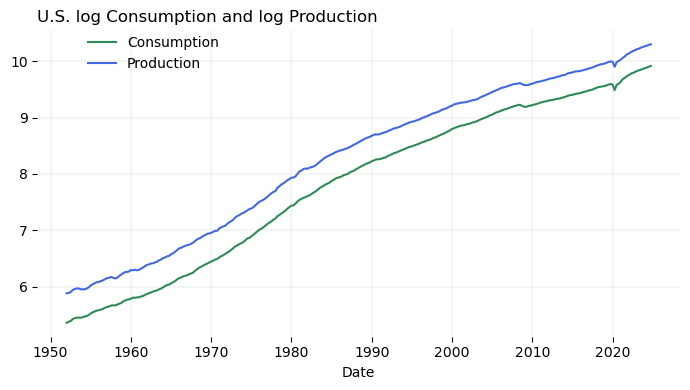

In [6]:
colors = {"Consumption": "seagreen", "Production": "royalblue"}

plt.figure(figsize=(7, 4))
plt.plot(data.index, data["PCEC"], color=colors["Consumption"], label="Consumption")
plt.plot(data.index, data["GDP"], color=colors["Production"], label="Production")
plt.xlabel('Date')
plt.ylabel('')
plt.title("U.S. log Consumption and log Production", loc='left')
plt.legend(loc=(0.07, 0.85), frameon=False)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(10))
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.tight_layout()
plt.show()

Plot of log Consumption (PCEC) vs log Production (GDP) to show correlation

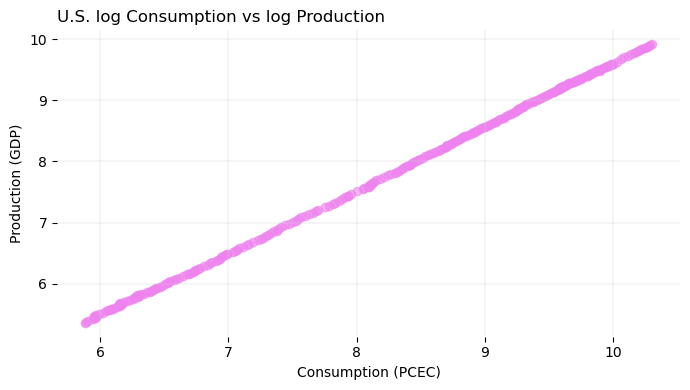

In [7]:
plt.figure(figsize=(7, 4))
plt.scatter(data['GDP'], data['PCEC'], color='violet', alpha=0.6)
plt.title('U.S. log Consumption vs log Production', loc='left')
plt.xlabel('Consumption (PCEC)')
plt.ylabel('Production (GDP)')

plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.tight_layout()
plt.show()

Evaluate correlation

In [8]:
correlation = data['PCEC'].corr(data['GDP'])
print(f"{correlation:.4f}")

0.9999


# 2. Stationarity Tests

Stationarity test for log GDP

In [9]:
kpss_test = sm.tsa.stattools.kpss(GDP)
print("KPSS Stationarity Test:")
print("p-value:", kpss_test[1])

KPSS Stationarity Test:
p-value: 0.01


Stationarity test for log Consumption

In [10]:
kpss_test = sm.tsa.stattools.kpss(PCEC)
print("KPSS Stationarity Test:")
print("p-value:", kpss_test[1])

KPSS Stationarity Test:
p-value: 0.01


# 3. Cointegration

Run Johansen Cointegration Test

In [11]:
ro.globalenv['data'] = data # copy data from Python to R

In [12]:
%%R
jotest <- urca::ca.jo(data.frame(data))
print(jotest@test.name)
jotab <- cbind(round(jotest@teststat, digits=2), jotest@cval)
colnames(jotab) <- c("stat", "10pct", "5pct", "1pct")
print(jotab)

[1] "Johansen-Procedure"
          stat 10pct  5pct  1pct
  2.79  6.50  8.18 11.65
 42.91 12.91 14.90 19.19


The output does not provide p-values, therefore the value of the test statistic needs to be compared for each hypothesized values of r with the critical values at 10pct, 5pct, and 1pct to determine the outcome of the test. 
  
Here, for H0: r = 0, test stat > (10pct or 5pct or 1pct) and hence we reject the null hypothesis of no cointegration. We conclude that log Production (GDP) and log Consumption (PCEC) are cointegrated.d.

Plot of deviations from equilibrium

In [13]:
reg = sm.OLS(data['GDP'], sm.add_constant(data['PCEC'])).fit()
res = pd.Series(reg.resid, index=data.index)

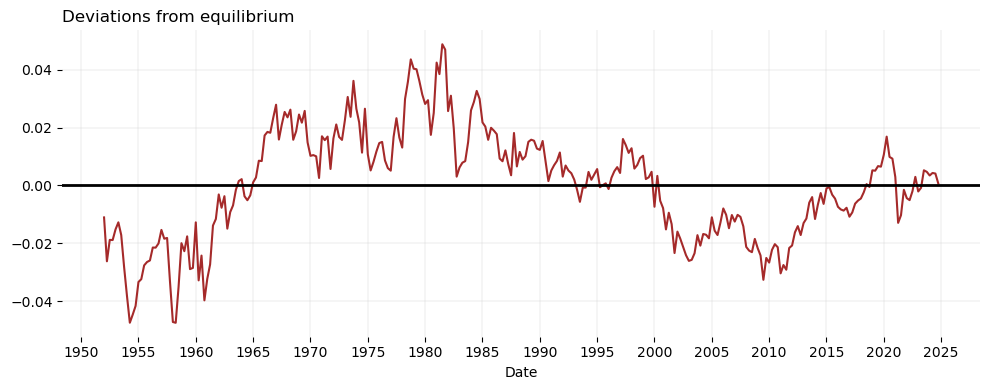

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(res.index, res, color='brown')
plt.axhline(y=0, color='black', linewidth=2)  
plt.xlabel('Date')
plt.ylabel('')
plt.title('Deviations from equilibrium', loc='left')
plt.legend(loc=(0.02, 0.8), frameon=False)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(1))
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

# 4. VEC Model and Forecast
Estimate VEC model with one lag and 1 cointegrating relationship (`r=1`)

In [15]:
%%R
VEC_model <- tsDyn::lineVar(data=data, lag=1, r=1, model="VEC", estim = "ML")

Forecast

In [16]:
%%R
h_steps <- 8 # forecast horizon
VEC_f <- stats::predict(VEC_model, n.ahead=h_steps)

In [17]:
h_steps = int(ro.globalenv['h_steps'][0])
VEC_f = ro.globalenv['VEC_f'] 
VEC_forecast = pd.DataFrame(VEC_f, columns=['PCEC','GDP'])  
id = data.index  
id_f = pd.date_range(start=id[-1] + pd.DateOffset(months=2), periods=h_steps, freq="3M")
VEC_forecast.index = id_f
VEC_forecast = np.exp(VEC_forecast) # from logs to levels

Plot

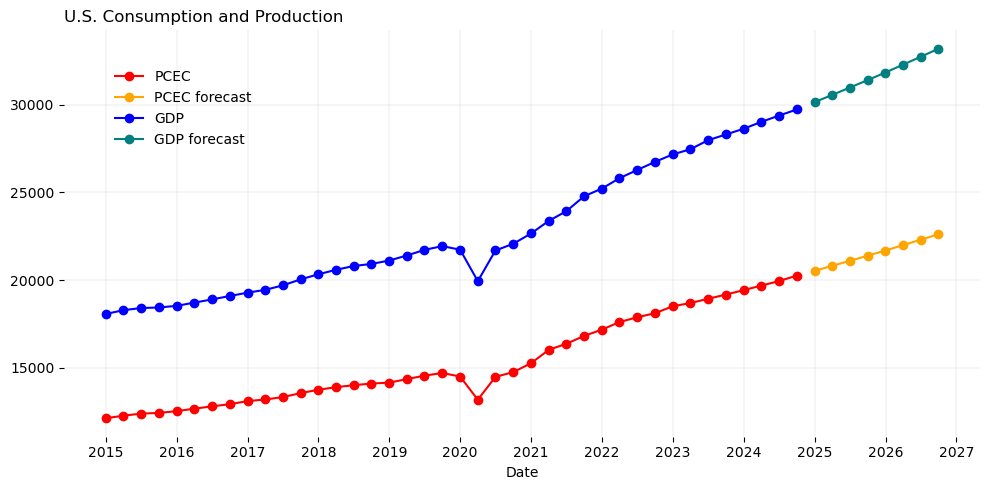

In [18]:
start_plot = pd.to_datetime('2015-01-01')
data_s = data[data.index >= start_plot]
data_s = np.exp(data_s) # from logs to levels

colors = {"PCEC": "red", "PCEC forecast": "orange",  "GDP": "blue", "GDP forecast": "teal"}

plt.figure(figsize=(10, 5))
plt.plot(data_s.index, data_s["PCEC"], color=colors["PCEC"], 
         label="PCEC", linestyle='-', marker='o')
plt.plot(VEC_forecast.index, VEC_forecast["PCEC"], color=colors["PCEC forecast"], 
         label="PCEC forecast", linestyle='-', marker='o')
plt.plot(data_s.index, data_s["GDP"], color=colors["GDP"], 
         label="GDP", linestyle='-', marker='o')
plt.plot(VEC_forecast.index, VEC_forecast["GDP"], color=colors["GDP forecast"], 
         label="GDP forecast", linestyle='-', marker='o')
plt.xlabel('Date')
plt.ylabel('')
plt.title("U.S. Consumption and Production", loc='left')
plt.legend(loc=(0.05, 0.7), frameon=False)
plt.grid(which='major', color='lightgrey', linewidth=0.3)
plt.box(False)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()